# Loading package

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import time

t = time.time()
scvi.settings.seed = 1234

/home/yahui/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yahui/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yahui/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:

In [2]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
dataset = 'Dataset1_Mouse_Spleen1'
adata_rna = sc.read_h5ad('../data/' + dataset + '/adata_RNA.h5ad')
adata_adt = sc.read_h5ad('../data/' + dataset + '/adata_Pro.h5ad')
adata_rna.var_names_make_unique()
adata_adt.var_names_make_unique()

/home/yahui/anaconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata_adt.var_names

Index(['CD29', 'CD3', 'F4_80', 'CD169_siglec', 'CD4', 'CD19', 'CD105', 'CD8',
       'B220_CD45R', 'Ly6C', 'CD31', 'CD68', 'EpCAM', 'CD163', 'Ly6G', 'CD38',
       'IgM', 'IgD', 'MadCAM1', 'CD20', 'CD11b'],
      dtype='object')

In [5]:
adata_rna.obs['batch'] = 'Thymus'
adata_rna.layers['counts'] = adata_rna.X.copy()

In [6]:
mdata = md.MuData({"rna": adata_rna, "protein": adata_adt})
mdata

MuData object with n_obs × n_vars = 2568 × 32306
  2 modalities
    rna:	2568 x 32285
      obs:	'batch'
      var:	'gene_ids', 'feature_types', 'genome'
      obsm:	'spatial'
      layers:	'counts'
    protein:	2568 x 21
      obsm:	'spatial'

In [7]:
mdata.mod['rna']

AnnData object with n_obs × n_vars = 2568 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    layers: 'counts'

In [8]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    layer="counts",
)
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
].copy()

In [9]:
mdata

MuData object with n_obs × n_vars = 2568 × 32306
  3 modalities
    rna:	2568 x 32285
      obs:	'batch'
      var:	'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg'
      obsm:	'spatial'
      layers:	'counts'
    protein:	2568 x 21
      obsm:	'spatial'
    rna_subset:	2568 x 4000
      obs:	'batch'
      var:	'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg'
      obsm:	'spatial'
      layers:	'counts'

In [10]:
mdata.update()

/home/yahui/anaconda3/envs/scvi/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


# Training totalVI model

In [11]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer=None,
    batch_key="batch",
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
        "batch_key": "rna_subset",
    },
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
vae = scvi.model.TOTALVI(mdata)

INFO     Computing empirical prior initialization for protein background.                                          


In [13]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/yahui/anaconda3/envs/scvi/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:306: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:13<00:00,  3.14it/s, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.49e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:13<00:00,  3.00it/s, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.49e+3]


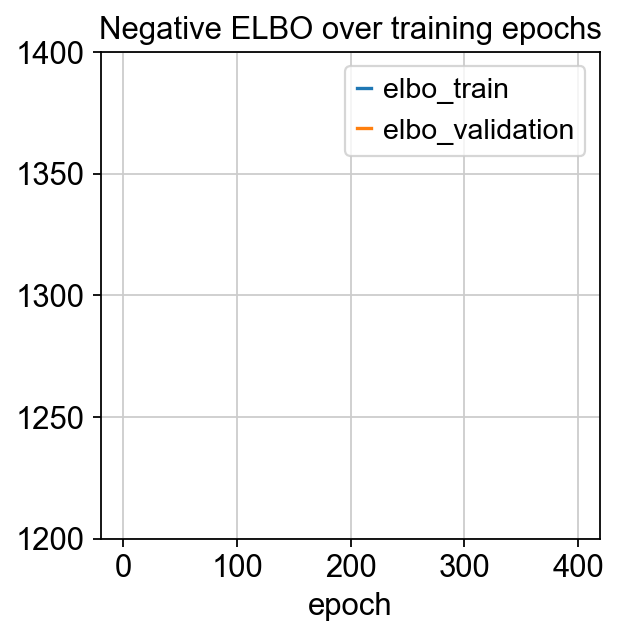

In [14]:
fig, ax = plt.subplots(1, 1)
vae.history["elbo_train"].plot(ax=ax, label="train")
vae.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(1200, 1400))
ax.legend()

# Reading totalVI model output

In [15]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]
# arbitrarily store latent in rna modality
rna.obsm["X_totalVI"] = vae.get_latent_representation()

In [16]:
#rna.write_h5ad('../adata_totalVI.h5ad')